
## 0. Importing libraries and FRVRS logs dataframe and creating helper tokenize method

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

%matplotlib inline
from datetime import timedelta
from nltk import ngrams, FreqDist, word_tokenize
from notebook_utils import NotebookUtilities
from numpy import arange
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import random
import re
import string

# Get all CSVs into one data frame
nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 109)


In [3]:

def ultimate_tokenize(sentence):
    
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    return word_tokenize(sentence.lower())


# Exploring Voice Capture Ngrams


Based on [hands-on-nltk-tutorial by hb20007](https://github.com/hb20007/hands-on-nltk-tutorial)

## 1. Understanding the process

In [43]:

def show_corpus_stats(sents_list):
    sent_count = len(sents_list)
    
    # Calculate the average word length
    word_ave = np.mean([len(word) for sent in sents_list for word in sent])
    
    print(f'The voice capture corpus contains {sent_count:,} sentences with an average of {word_ave:0.2} words each.')

In [44]:

mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
df = frvrs_logs_df[mask_series]
# display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)
# voice_capture_text = '\n'.join(df.voice_capture_message)

voice_capture_tokens_words = [ultimate_tokenize(x) for x in df.voice_capture_message]
show_corpus_stats(voice_capture_tokens_words)

The voice capture corpus contains 34,310 sentences with an average of 3.7 words each.


In [5]:

voice_capture_tokens_chars = list(voice_capture_tokens_words[0][0])
voice_capture_tokens_chars

['s', 'e', 't']

In [6]:

voice_capture_tokens_words_unigrams = [list(ngrams(x, 1)) for x in voice_capture_tokens_words]
for x in voice_capture_tokens_words_unigrams[0]:
    print(x)

('set',)
('lay',)
('down',)


In [7]:

voice_capture_tokens_words_bigrams = [
    list(
        ngrams(x, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')
    ) for x in voice_capture_tokens_words
]
for x in voice_capture_tokens_words_bigrams[0]:
    print(x)

('_', 'set')
('set', 'lay')
('lay', 'down')
('down', '_')


In [8]:

unigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_unigrams]
for freqdist_obj in unigram_freqdists_list:
    freqdist_obj.pprint()
    break

FreqDist({('set',): 1, ('lay',): 1, ('down',): 1})


In [9]:

bigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_bigrams]
for freqdist_obj in bigram_freqdists_list:
    freqdist_obj.pprint()
    break

FreqDist({('_', 'set'): 1, ('set', 'lay'): 1, ('lay', 'down'): 1, ('down', '_'): 1})


In [10]:

unigram_dict = dict()
for freqdist_obj in unigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in unigram_dict: v += unigram_dict[k]
        unigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(unigram_dict)

{'strangely': 1, 'trucking': 1, 'ems': 12, 'traveled': 1, 'mercy': 3}

In [11]:

bigram_dict = dict()
for freqdist_obj in bigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in bigram_dict: v += bigram_dict[k]
        bigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(bigram_dict)

{'had _': 3, 'nice bleed': 1, 'uneven asymmetrical': 1, 'about table': 1, 'pull somebody': 1}

In [12]:

unigram_freqs = sorted(unigram_dict.items(), key=operator.itemgetter(1), reverse=True)
unigram_freqs[:10]

[('ok', 8152), ('you', 7998), ('i', 4813), ('can', 3513), ('to', 2964), ('the', 2801), ('oh', 2713), ('alright', 2643), ('that', 2558), ('so', 2552)]

In [13]:

bigram_freqs = sorted(bigram_dict.items(), key=operator.itemgetter(1), reverse=True)
bigram_freqs[:10]

[('_ ok', 5208), ('ok _', 4823), ('are you', 2078), ('_ oh', 2008), ('_ alright', 1902), ('_ are', 1747), ('you hurt', 1674), ('hurt _', 1642), ('_ modbutton', 1434), ('gon na', 1423)]

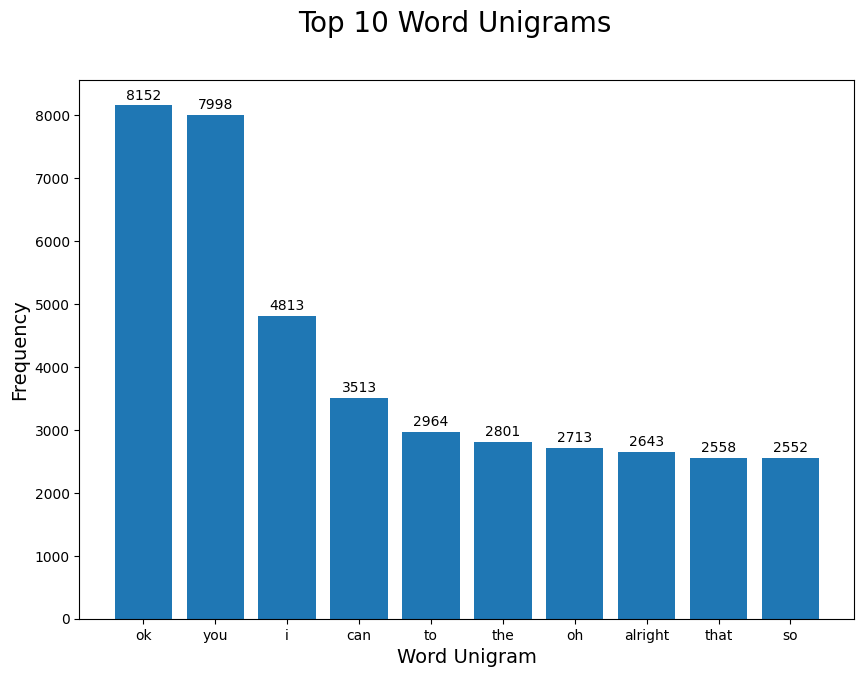

In [14]:

labels, values = zip(*unigram_freqs[:10])
indexes = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close.

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indexes, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Unigrams', fontsize=20)
plt.xlabel('Word Unigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing:
ax.set_xticks(indexes)
# Replace the tick numbers with strings:
ax.set_xticklabels(labels)

plt.show()
# plt.savefig('top10EnglishWordUnigrams.png')

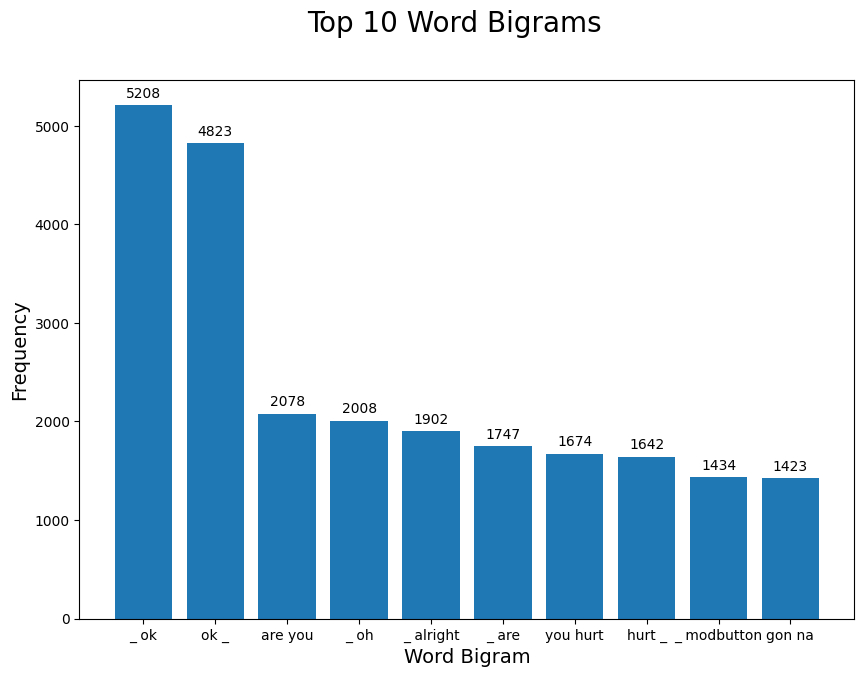

In [15]:

labels, values = zip(*bigram_freqs[:10])
indexes = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close.

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indexes, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Bigrams', fontsize=20)
plt.xlabel('Word Bigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing:
ax.set_xticks(indexes)
# Replace the tick numbers with strings:
ax.set_xticklabels(labels)

plt.show()
# plt.savefig('top10EnglishWordBigrams.png')


# Finding Unusual Words


Based on [hands-on-nltk-tutorial by hb20007](https://github.com/hb20007/hands-on-nltk-tutorial)


## 1. Importing and exploring the words corpus

In [17]:

from nltk.corpus import words

words.readme().replace('\n', ' ')

'Wordlists  en: English, http://en.wikipedia.org/wiki/Words_(Unix) en-basic: 850 English words: C.K. Ogden in The ABC of Basic English (1932) '

In [18]:

words

<WordListCorpusReader in 'C:\\Users\\DaveBabbitt\\AppData\\Roaming\\nltk_data\\corpora\\words'>

In [19]:

words.fileids()

['en', 'en-basic']

In [20]:

random.sample(words.words('en'), 10)

['palmist', 'Dob', 'abscise', 'ruer', 'bulked', 'arterioarctia', 'manism', 'cedrol', 'foehn', 'Medina']

In [21]:

random.sample(words.words('en-basic'), 10)

['animal', 'spoon', 'foot', 'voice', 'clear', 'face', 'band', 'increase', 'do', 'use']

In [42]:

len(words.words('en'))

235886

In [23]:

len(words.words('en-basic'))

850


## 2. Tokenizing text

In [49]:

from nltk import word_tokenize

words_list = [w for s in df.voice_capture_message for w in s.split()]
text_tokenized = word_tokenize(' '.join(words_list))
print(f'The voice capture corpus contains {len(text_tokenized):,} words.')
random.sample(text_tokenized, 10)

The voice capture corpus contains 183,588 words.


['a', 'yeah', 'anything', 'a', "'s", 'groan', 'hand', 'time', 'Yep', "n't"]

## 3. Finding unusual words

In [53]:

words_list = [w.lower() for w in text_tokenized if w.isalpha()]
print(f'The voice capture corpus contains a set of {len(set(words_list)):,} unpunctuated tokens.')
text_vocab = set(random.sample(words_list, 320))
english_vocab = set(w.lower() for w in words.words())
print(f'The English vocabulary contains a set of {len(english_vocab):,} unpunctuated tokens.')
text_vocab - english_vocab

The voice capture corpus contains a set of 3,472 unpunctuated tokens.
The English vocabulary contains a set of 234,377 unpunctuated tokens.


{'commands', 'anymore', 'hands', 'kid', 'looks', 'burns', 'waivers', 'cranking', 'jacked', 'has', 'expected', 'modbutton', 'okay', 'meds', 'netflix'}

In [51]:

random.sample([w.lower() for w in words.words()], 10)

['nubiform', 'overlong', 'shuddersome', 'swanmark', 'conjunctur', 'tampang', 'kirkyard', 'retake', 'monont', 'unenraged']

In [55]:

# Note .isalpha() removes punctuation tokens.
# However, tokens with a hyphen like 'browser-based' are totally skipped over because .isalpha() would be false.
english_vocab = set(w.lower() for w in words.words())
text_vocab = set(words_list)
unusual_set = text_vocab - english_vocab
print(f'The Unusual Set contains a set of {len(unusual_set):,} unpunctuated tokens.')
unusual_dict = {}
for word in unusual_set:
    if word in unigram_dict:
        # print(word, unigram_dict[word])
        unusual_dict[word] = unigram_dict[word]
unusual_freqs = sorted(unusual_dict.items(), key=operator.itemgetter(1), reverse=True)
unusual_freqs[:10]

The Unusual Set contains a set of 813 unpunctuated tokens.


[('im', 1769), ('modbutton', 1434), ('okay', 389), ('looks', 325), ('injuries', 238), ('guys', 215), ('stairs', 172), ('gotcha', 165), ('has', 162), ('pulses', 101)]